# GAN - MNIST Handwriting

- ![GAN](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/11000153/g1.jpg)
- Convolution layer + Fully connected  layer

In [1]:
%matplotlib inline
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os

import keras
from keras import backend as K
from keras import models, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.datasets import mnist

from PIL import Image

/Users/skim0119/venv/GenP3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/skim0119/venv/GenP3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
K.set_image_data_format('channels_first')

## Prepare Data

In [3]:
train_size = 8

def load_data(size):
    (X_train, y_train), (_, _) = mnist.load_data()
    X_train = X_train[:size]
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = X_train.reshape((X_train.shape[0], 1) + X_train.shape[1:])
    return X_train

X_train = load_data(train_size)

### Visualize

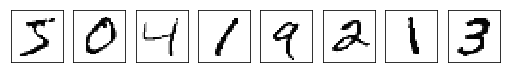

In [4]:
ncol = 10
nrow = (train_size/10) + 1
fig = plt.figure(figsize=(ncol+1,nrow+1))

for i in range(train_size):
    subplot = fig.add_subplot(nrow, ncol, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(X_train[i].reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')

## Model

In [5]:
input_dim = 10

def mse_4d(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=(1,2,3))

### Generator Network

In [6]:
def generator_model():
    model = Sequential()
    model.add(layers.Dense(1024, activation='tanh', input_dim=input_dim))
    model.add(layers.Dense(128 * 7 * 7, activation='tanh'))
    model.add(layers.BatchNormalization())
    model.add(layers.Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
    model.add(layers.UpSampling2D(size=(2, 2)))
    model.add(layers.Conv2D(64, (5, 5),
                            padding='same',
                            activation='tanh'))
    model.add(layers.UpSampling2D(size=(2, 2)))
    model.add(layers.Conv2D(1, (5, 5),
                            padding='same',
                            activation='tanh'))
    
    model.compile(loss='binary_crossentropy',
                 optimizer=SGD(lr=0.0005, momentum=0.9, nesterov=True))
    return model

### Discriminator Network

In [7]:
def discriminator_model():
    model = Sequential()
    model.add(layers.Conv2D(64, (5, 5),
                            padding='same',
                            activation='tanh',
                            input_shape=(1, 28, 28)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (5, 5),
                            activation='tanh'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='tanh'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                 optimizer=SGD(lr=0.0005, momentum=0.9, nesterov=True))
    return model

### Total Network

In [8]:
# generator and discriminator
generator = generator_model()
discriminator = discriminator_model()

# connected total network
total_model = Sequential()
total_model.add(generator)
discriminator.trainable = False
total_model.add(discriminator)
total_model.compile(loss='binary_crossentropy',
                     optimizer=SGD(lr=0.0005, momentum=0.9, nesterov=True))
discriminator.trainable = True

## Training

In [9]:
n_iter_D = 1
n_iter_G = 5

def get_z(length):
    return np.random.uniform(-1, 1, (length, input_dim))

def get_x(X_train, index, BATCH_SIZE):
    return X_train[index * BATCH_SIZE:(index + 1) * BATCH_SIZE]

def train(x, epochs=1):
    d_loss, g_loss = [], []
    length = x.shape[0]
    for epoch in range(epochs):
        for i in range(n_iter_D):
            # Discriminator forward-propagation
            z = get_z(length)
            w = generator.predict(z, verbose=0)
            xw = np.concatenate((x, w))
            # Discriminator back-propagation
            y2 = np.array([1] * length + [0] * length)
            d_loss.append(discriminator.train_on_batch(xw, y2))
            
        for j in range(n_iter_G):
            # Total Forward-propagation
            z = get_z(length)
            discriminator.trainable = False
            # Total Backpropagation
            y2 = np.array([1]*length)
            g_loss.append(total_model.train_on_batch(z, y2))
            discriminator.trainable = True

    return d_loss, g_loss
    
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num) / width))
    shape = generated_images.shape[2:]
    image = np.zeros((height * shape[0], width * shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index / width)
        j = index % width
        image[i * shape[0]:(i + 1) * shape[0],
        j * shape[1]:(j + 1) * shape[1]] = img[0, :, :]
    return image

def display_image(generated_images, n_repeat, index):
    image = combine_images(generated_images)
    #image = image * 127.5 + 127.5
    
    
    plt.imshow(image, vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()
    #Image.fromarray(image.astype(np.uint8)).save(
    #    output_fold + '/' +
    #    str(epoch) + "_" + str(index) + ".png")

Output folder is " weights "
n_train is 0
Number of batches 2


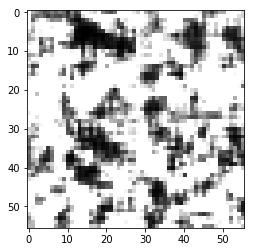

n_train is 10
Number of batches 2


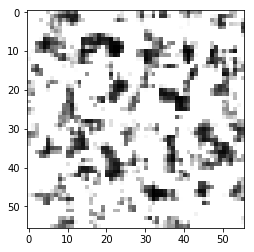

n_train is 20
Number of batches 2


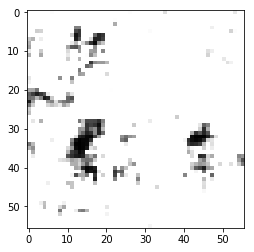

n_train is 30
Number of batches 2


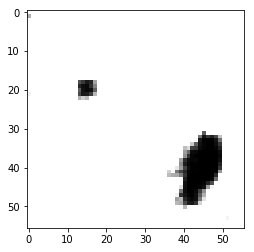

n_train is 40
Number of batches 2


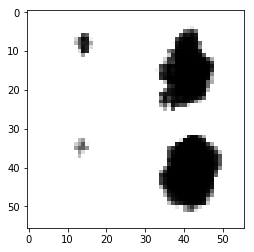

n_train is 50
Number of batches 2


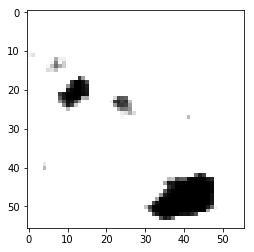

n_train is 60
Number of batches 2


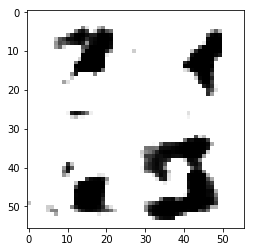

n_train is 70
Number of batches 2


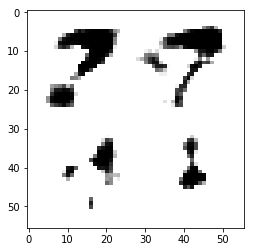

n_train is 80
Number of batches 2


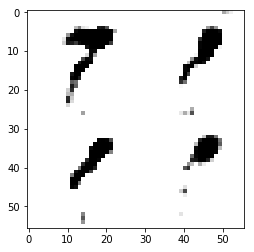

n_train is 90
Number of batches 2


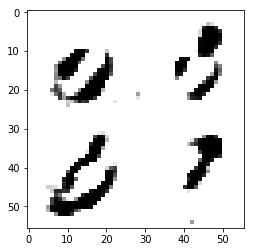

n_train is 100
Number of batches 2


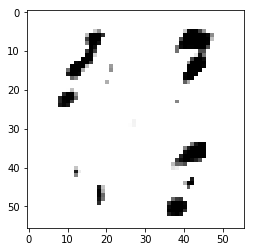

n_train is 110
Number of batches 2


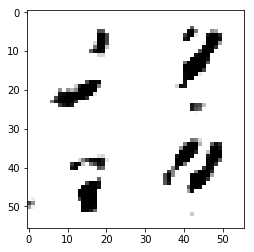

n_train is 120
Number of batches 2


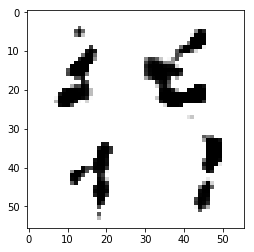

n_train is 130
Number of batches 2


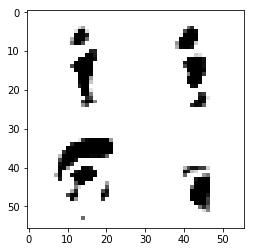

n_train is 140
Number of batches 2


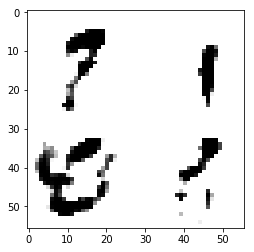

n_train is 150
Number of batches 2


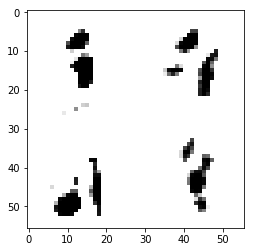

n_train is 160
Number of batches 2


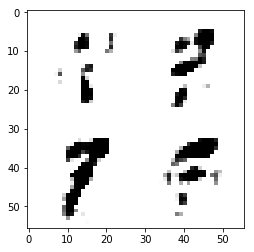

n_train is 170
Number of batches 2


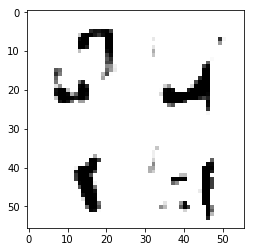

n_train is 180
Number of batches 2


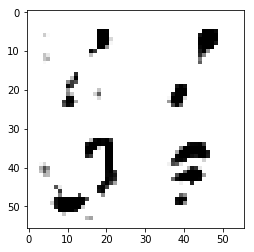

n_train is 190
Number of batches 2


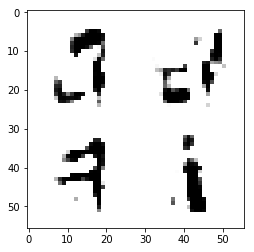

n_train is 200
Number of batches 2


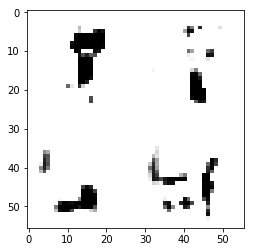

n_train is 210
Number of batches 2


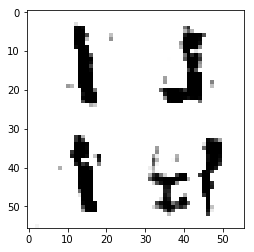

n_train is 220
Number of batches 2


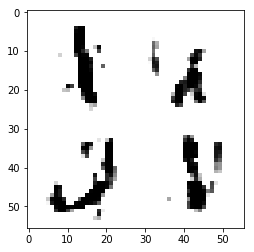

n_train is 230
Number of batches 2


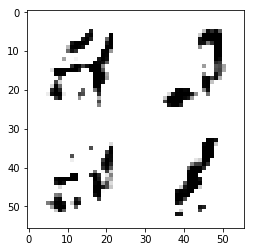

n_train is 240
Number of batches 2


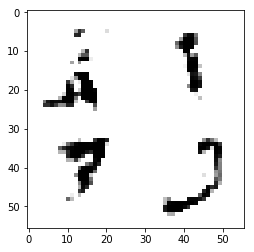

n_train is 250
Number of batches 2


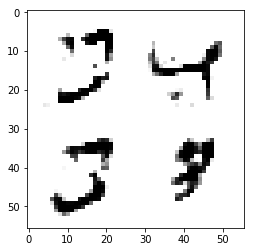

n_train is 260
Number of batches 2


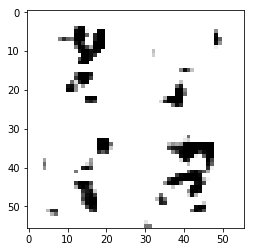

n_train is 270
Number of batches 2


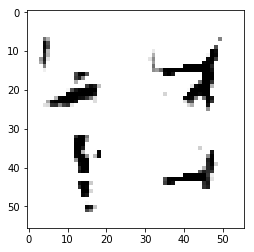

n_train is 280
Number of batches 2


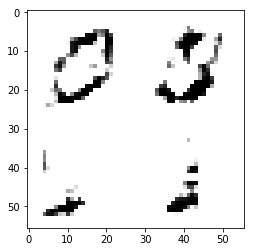

n_train is 290
Number of batches 2


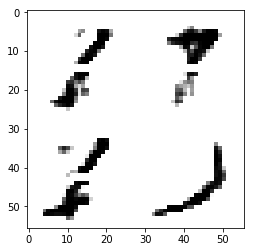

n_train is 300
Number of batches 2


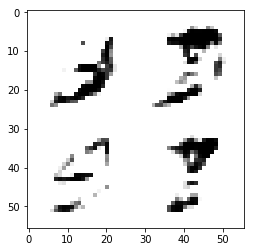

n_train is 310
Number of batches 2


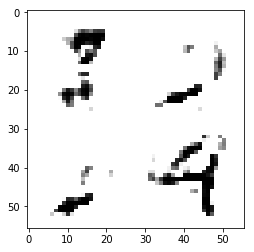

n_train is 320
Number of batches 2


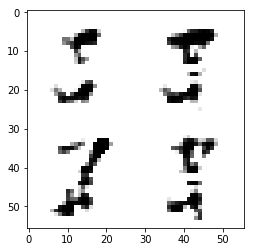

n_train is 330
Number of batches 2


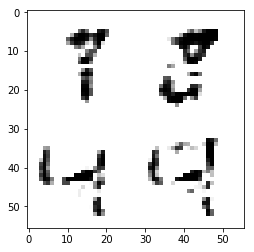

n_train is 340
Number of batches 2


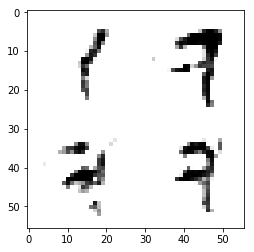

n_train is 350
Number of batches 2


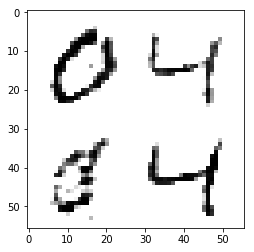

n_train is 360
Number of batches 2


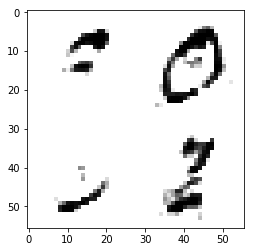

n_train is 370
Number of batches 2


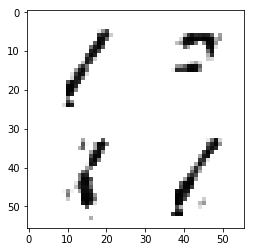

n_train is 380
Number of batches 2


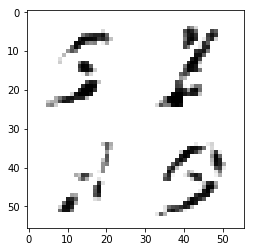

n_train is 390
Number of batches 2


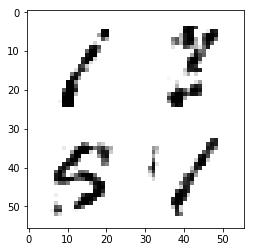

n_train is 400
Number of batches 2


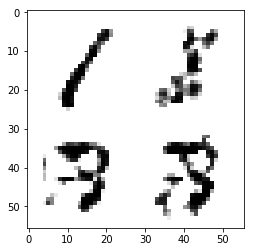

n_train is 410
Number of batches 2


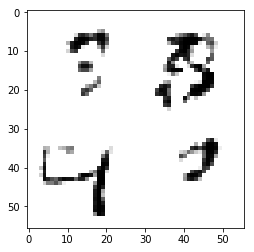

n_train is 420
Number of batches 2


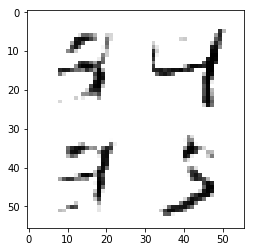

n_train is 430
Number of batches 2


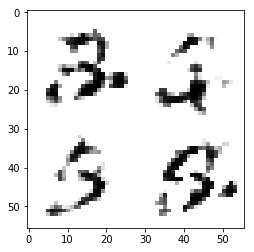

n_train is 440
Number of batches 2


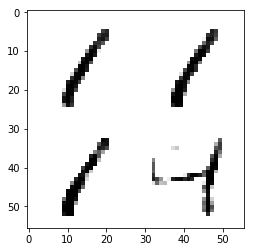

n_train is 450
Number of batches 2


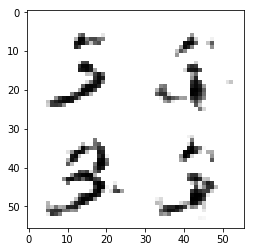

n_train is 460
Number of batches 2


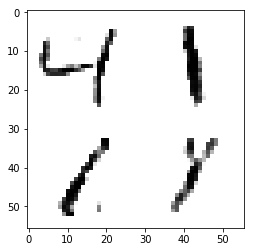

n_train is 470
Number of batches 2


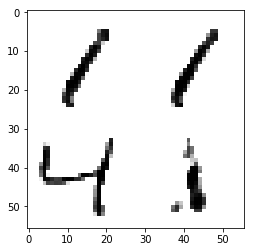

n_train is 480
Number of batches 2


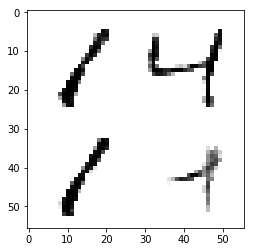

n_train is 490
Number of batches 2


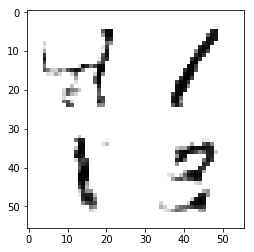

n_train is 500
Number of batches 2


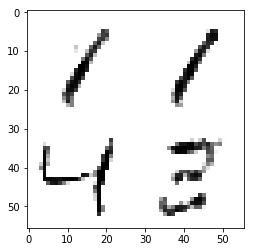

n_train is 510
Number of batches 2


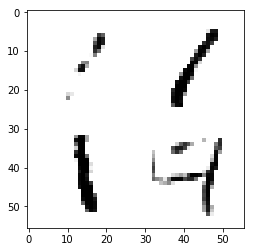

n_train is 520
Number of batches 2


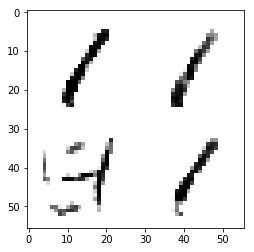

n_train is 530
Number of batches 2


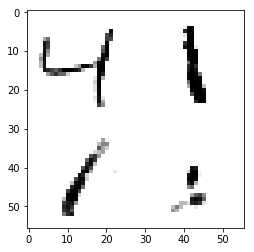

n_train is 540
Number of batches 2


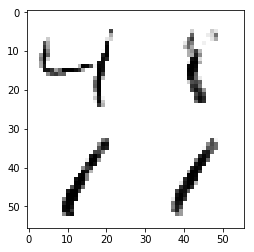

n_train is 550
Number of batches 2


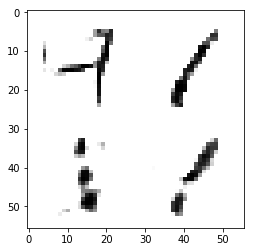

n_train is 560
Number of batches 2


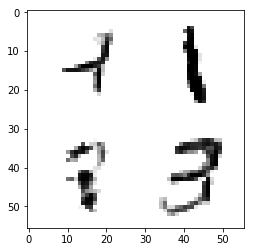

n_train is 570
Number of batches 2


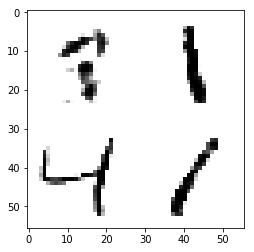

n_train is 580
Number of batches 2


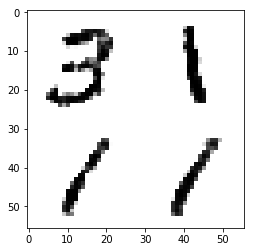

n_train is 590
Number of batches 2


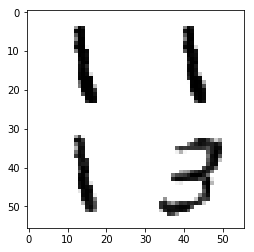

n_train is 600
Number of batches 2


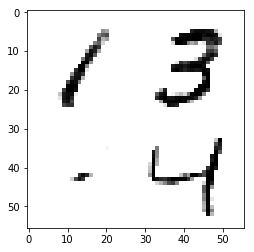

n_train is 610
Number of batches 2


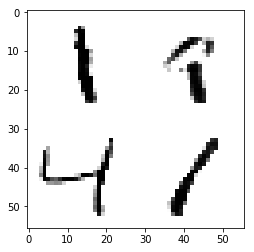

n_train is 620
Number of batches 2


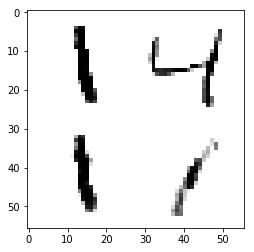

n_train is 630
Number of batches 2


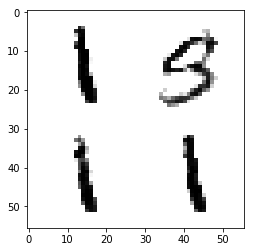

n_train is 640
Number of batches 2


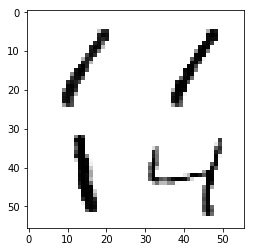

n_train is 650
Number of batches 2


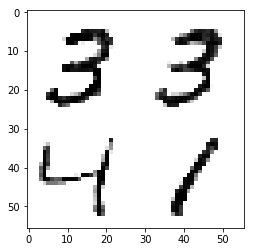

n_train is 660
Number of batches 2


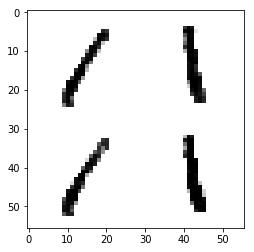

n_train is 670
Number of batches 2


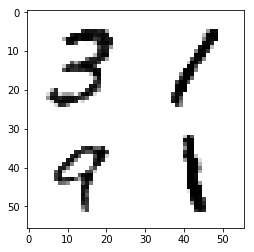

n_train is 680
Number of batches 2


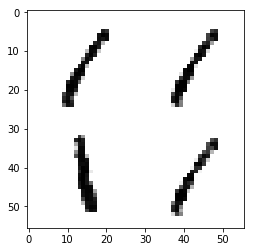

n_train is 690
Number of batches 2


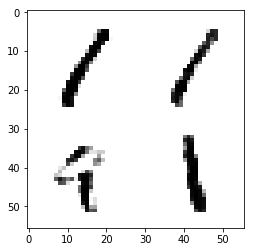

n_train is 700
Number of batches 2


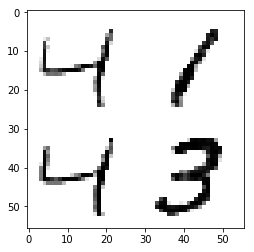

n_train is 710
Number of batches 2


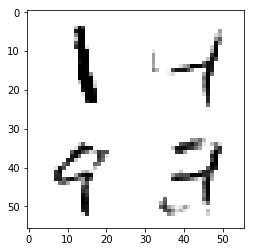

n_train is 720
Number of batches 2


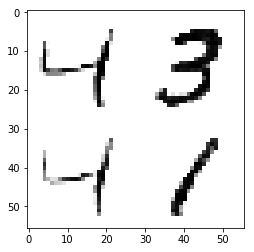

n_train is 730
Number of batches 2


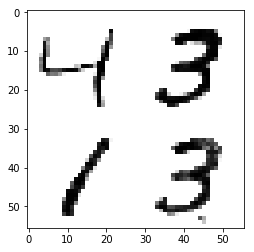

n_train is 740
Number of batches 2


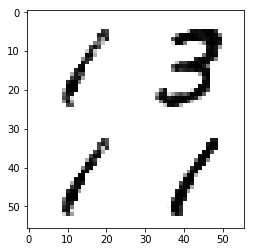

n_train is 750
Number of batches 2


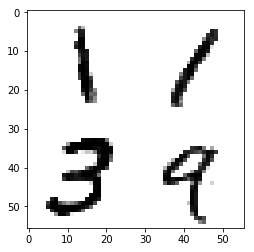

n_train is 760
Number of batches 2


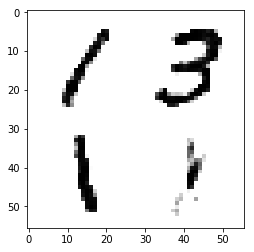

n_train is 770
Number of batches 2


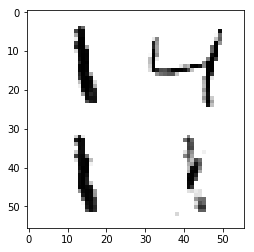

n_train is 780
Number of batches 2


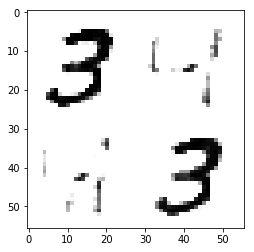

n_train is 790
Number of batches 2


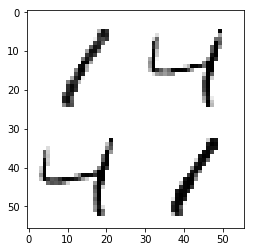

n_train is 800
Number of batches 2


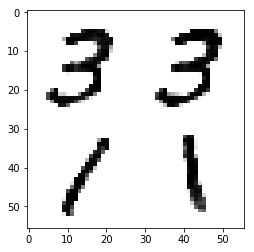

n_train is 810
Number of batches 2


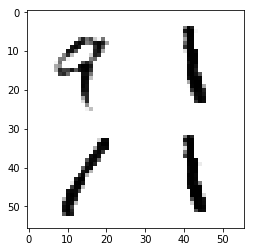

n_train is 820
Number of batches 2


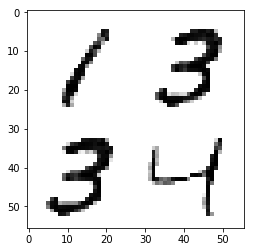

n_train is 830
Number of batches 2


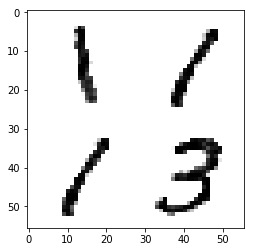

n_train is 840
Number of batches 2


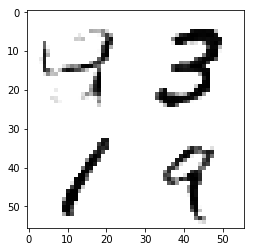

n_train is 850
Number of batches 2


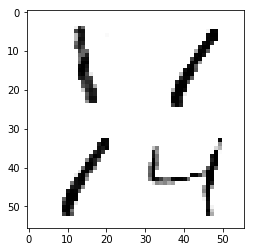

n_train is 860
Number of batches 2


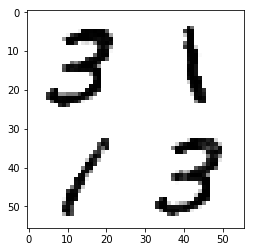

n_train is 870
Number of batches 2


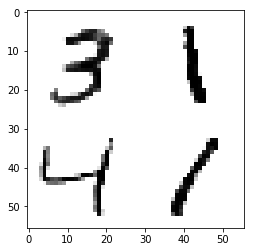

n_train is 880
Number of batches 2


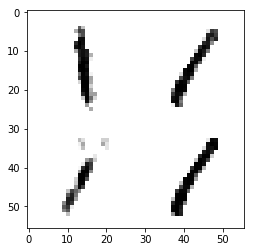

n_train is 890
Number of batches 2


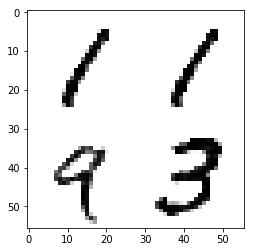

n_train is 900
Number of batches 2


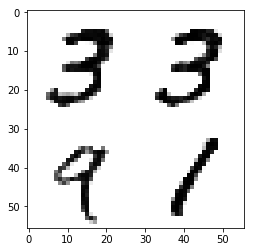

n_train is 910
Number of batches 2


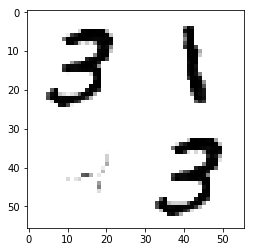

n_train is 920
Number of batches 2


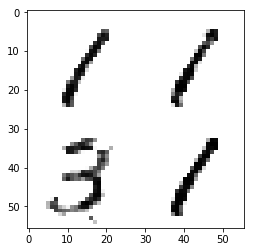

n_train is 930
Number of batches 2


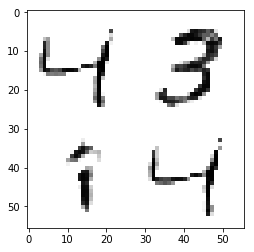

n_train is 940
Number of batches 2


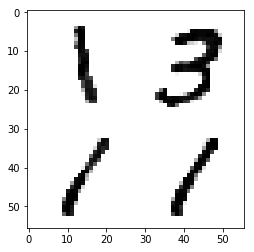

n_train is 950
Number of batches 2


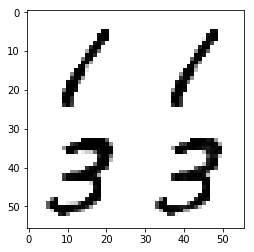

n_train is 960
Number of batches 2


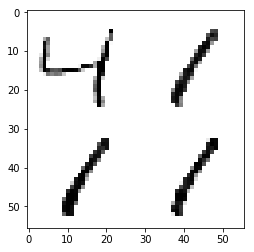

n_train is 970
Number of batches 2


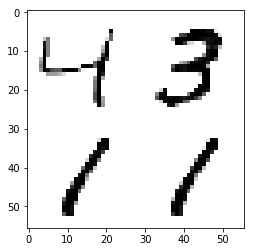

n_train is 980
Number of batches 2


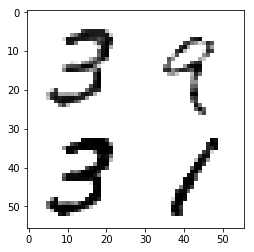

n_train is 990
Number of batches 2


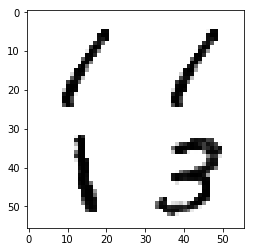

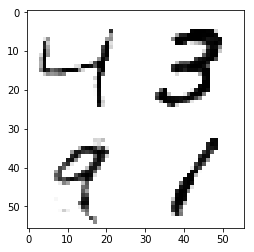

In [10]:
BATCH_SIZE = 4
output_fold = 'weights'
n_repeat = 1000

os.makedirs(output_fold, exist_ok=True)
print('Output folder is "', output_fold,'"')

d_loss_ll = []
g_loss_ll = []


for i in range(n_repeat):
    if i % 10 == 0:
        print("n_train is", i)
        print("Number of batches", int(X_train.shape[0] / BATCH_SIZE))

    d_loss_l = []
    g_loss_l = []
    for index in range(int(X_train.shape[0] / BATCH_SIZE)):
        x = get_x(X_train, index, BATCH_SIZE)

        d_loss, g_loss = train(x)

        d_loss_l += d_loss
        g_loss_l += g_loss

    if i % 10 == 0 or i == n_repeat - 1:
        z = get_z(x.shape[0])
        w = generator.predict(z, verbose=0)
        image = combine_images(w)
        
        canvas = plt.imshow(image, vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')
        plt.show()

    d_loss_ll += d_loss_l
    g_loss_ll += g_loss_l

generator.save_weights(output_fold + '/' + '2.generator', True)
discriminator.save_weights(output_fold + '/' + '2.discriminator', True)

## Result

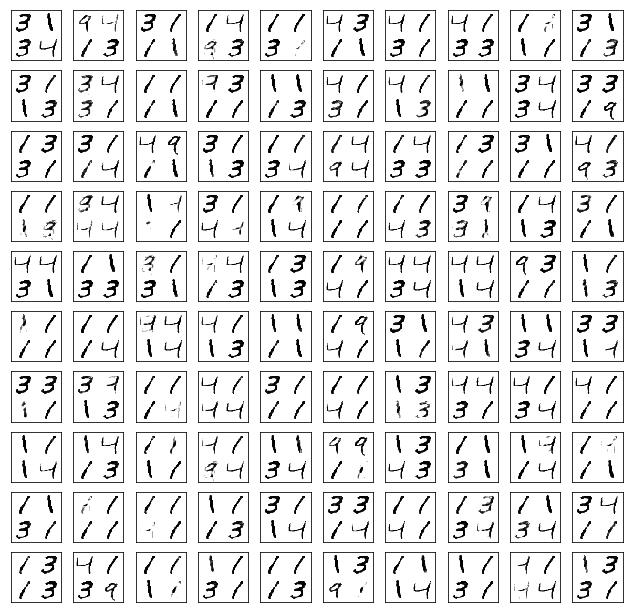

In [12]:
test_size = 100
nrow = (test_size/10) + 1
fig = plt.figure(figsize=(ncol+1,nrow+1))

for i in range(test_size):
    z = get_z(BATCH_SIZE)
    w = generator.predict(z, verbose=0)
    image = combine_images(w)
    
    subplot = fig.add_subplot(nrow, ncol, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(image, vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')